In [284]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, LSTM, GRU
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import math

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

np.random.seed(123)
tf.random.set_seed(123)

In [285]:
df=pd.read_csv('./HINDUNILVR.csv',index_col='Date',parse_dates=True)

In [286]:
df

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,HINDLEVER,EQ,2136.60,2300.0,2307.55,2300.00,2307.55,2307.55,2307.08,24903,5.745330e+12,NaN,NaN,NaN
2000-01-04,HINDLEVER,EQ,2307.55,2381.0,2381.00,2250.00,2270.00,2281.05,2298.15,58514,1.344740e+13,NaN,NaN,NaN
2000-01-05,HINDLEVER,EQ,2281.05,2200.0,2250.00,2105.00,2183.50,2199.90,2211.17,80296,1.775482e+13,NaN,NaN,NaN
2000-01-06,HINDLEVER,EQ,2199.90,2224.9,2360.00,2210.00,2300.00,2288.20,2301.80,190032,4.374157e+13,NaN,NaN,NaN
2000-01-07,HINDLEVER,EQ,2288.20,2300.0,2452.00,2282.25,2395.00,2412.95,2380.24,192582,4.583919e+13,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,HINDUNILVR,EQ,2307.75,2324.0,2369.80,2311.00,2367.70,2360.65,2340.89,1946867,4.557405e+14,85684.0,1289103.0,0.6621
2021-04-27,HINDUNILVR,EQ,2360.65,2363.0,2386.45,2352.95,2378.00,2379.85,2374.40,1668456,3.961583e+14,84641.0,1089882.0,0.6532
2021-04-28,HINDUNILVR,EQ,2379.85,2380.0,2445.00,2366.30,2404.00,2406.55,2414.15,1951215,4.710522e+14,84910.0,1024216.0,0.5249


In [287]:
df['Date']=df.index

In [288]:
start_date='2016-01-01'
end_date='2020-12-31'
mask=(df['Date']>=start_date)&(df['Date']<=end_date)

In [289]:
df=df.loc[mask]

In [290]:
df=df.drop(columns=['Series','Symbol','Open','High','Low','Last','Close','VWAP','Volume','Turnover','Trades','Deliverable Volume','%Deliverble','Date'])

In [291]:
Ntest=math.trunc(0.3*len(df))
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [292]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

In [293]:
df['Diff Prev Close']=df['Prev Close'].diff()

In [294]:
series=df['Diff Prev Close'].dropna().to_numpy()

T=50
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (1187, 50) Y.shape (1187,)


In [295]:
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

LSTM+CNN

In [296]:
i=Input(shape=(T,1))
x=LSTM(200,return_sequences=True)(i)
x=LSTM(200,return_sequences=True)(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Conv1D(25,3,activation='relu')(i)
x=MaxPooling1D(2)(x)
x=Conv1D(50,3,activation='relu')(x)
x=GlobalMaxPool1D()(x)
x=Dense(1)(x)
model_lstm_cnn=Model(i,x)
model_lstm_cnn.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 conv1d_14 (Conv1D)          (None, 48, 25)            100       
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 24, 25)           0         
 1D)                                                             
                                                                 
 conv1d_15 (Conv1D)          (None, 22, 50)            3800      
                                                                 
 global_max_pooling1d_15 (Gl  (None, 50)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_63 (Dense)            (None, 1)                 51 

In [297]:
check_point_lstm_cnn=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [298]:
model_lstm_cnn.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [299]:
r=model_lstm_cnn.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_lstm_cnn]
)

Epoch 1/100
26/26 [==============================] - 1s 15ms/step - loss: 262.3056 - mae: 11.8258 - mse: 262.3056 - val_loss: 1643.1560 - val_mae: 25.7205 - val_mse: 1643.1560
Epoch 2/100
26/26 [==============================] - 0s 7ms/step - loss: 259.4212 - mae: 11.7361 - mse: 259.4212 - val_loss: 1658.8108 - val_mae: 26.2277 - val_mse: 1658.8108
Epoch 3/100
26/26 [==============================] - 0s 7ms/step - loss: 256.7941 - mae: 11.6791 - mse: 256.7941 - val_loss: 1677.2268 - val_mae: 26.5373 - val_mse: 1677.2268
Epoch 4/100
26/26 [==============================] - 0s 8ms/step - loss: 254.3295 - mae: 11.6105 - mse: 254.3295 - val_loss: 1669.1752 - val_mae: 26.4050 - val_mse: 1669.1752
Epoch 5/100
26/26 [==============================] - 0s 7ms/step - loss: 253.5466 - mae: 11.6096 - mse: 253.5466 - val_loss: 1658.0540 - val_mae: 26.1808 - val_mse: 1658.0540
Epoch 6/100
26/26 [==============================] - 0s 8ms/step - loss: 255.1172 - mae: 11.6347 - mse: 255.1172 - val_loss:

LSTM+GRU

In [300]:
i=Input(shape=(T,1))
x=LSTM(200,return_sequences=True)(i)
x=LSTM(200,return_sequences=True)(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=GRU(200,return_sequences=True)(x)
x=GRU(200,return_sequences=True)(x)
x=GlobalMaxPool1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_lstm_gru=Model(i,x)
model_lstm_gru.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 lstm_32 (LSTM)              (None, 50, 200)           161600    
                                                                 
 lstm_33 (LSTM)              (None, 50, 200)           320800    
                                                                 
 dense_64 (Dense)            (None, 50, 100)           20100     
                                                                 
 dense_65 (Dense)            (None, 50, 50)            5050      
                                                                 
 gru_16 (GRU)                (None, 50, 200)           151200    
                                                                 
 gru_17 (GRU)                (None, 50, 200)           241

In [301]:
check_point_lstm_gru=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [302]:
model_lstm_gru.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [303]:
r=model_lstm_gru.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_lstm_gru]
)

Epoch 1/100
26/26 [==============================] - 24s 615ms/step - loss: 261.9463 - mae: 11.8093 - mse: 261.9463 - val_loss: 1592.9653 - val_mae: 25.4935 - val_mse: 1592.9653
Epoch 2/100
26/26 [==============================] - 14s 549ms/step - loss: 261.0107 - mae: 11.7821 - mse: 261.0107 - val_loss: 1592.3108 - val_mae: 25.5169 - val_mse: 1592.3108
Epoch 3/100
26/26 [==============================] - 14s 548ms/step - loss: 260.8368 - mae: 11.7834 - mse: 260.8368 - val_loss: 1591.7948 - val_mae: 25.5371 - val_mse: 1591.7948
Epoch 4/100
26/26 [==============================] - 14s 546ms/step - loss: 260.4761 - mae: 11.7577 - mse: 260.4761 - val_loss: 1592.1324 - val_mae: 25.5122 - val_mse: 1592.1324
Epoch 5/100
26/26 [==============================] - 14s 547ms/step - loss: 260.5261 - mae: 11.7838 - mse: 260.5261 - val_loss: 1591.7867 - val_mae: 25.5269 - val_mse: 1591.7867
Epoch 6/100
26/26 [==============================] - 14s 548ms/step - loss: 260.8989 - mae: 11.7812 - mse: 260

Predictions



In [304]:
train_idx[:T+1]=False

In [305]:
Ptrain_lstm_cnn=model_lstm_cnn.predict(Xtrain).flatten()
Ptest_lstm_cnn=model_lstm_cnn.predict(Xtest).flatten()

In [306]:
Ptrain_lstm_gru=model_lstm_gru.predict(Xtrain).flatten()
Ptest_lstm_gru=model_lstm_gru.predict(Xtest).flatten()

In [ ]:
df.loc[train_idx,'Diff LSTM+CNN train prediction']=Ptrain_lstm_cnn
df.loc[test_idx,'Diff LSTM+CNN test prediction']=Ptest_lstm_cnn

In [307]:
df.loc[train_idx,'Diff LSTM+GRU train prediction']=Ptrain_lstm_gru
df.loc[test_idx,'Diff LSTM+GRU test prediction']=Ptest_lstm_gru

In [308]:
df['Shift Prev Close']=df['Prev Close'].shift(1)
prev=df['Shift Prev Close']

In [309]:
last_train=train.iloc[-1]['Prev Close']

In [310]:
df.loc[train_idx,'train_LSTM_CNN']=prev[train_idx]+Ptrain_lstm_cnn
df.loc[test_idx,'Prediction_LSTM_CNN']=prev[test_idx]+Ptest_lstm_cnn

In [311]:
df.loc[train_idx,'train_LSTM_GRU']=prev[train_idx]+Ptrain_lstm_gru
df.loc[test_idx,'Prediction_LSTM_GRU']=prev[test_idx]+Ptest_lstm_gru

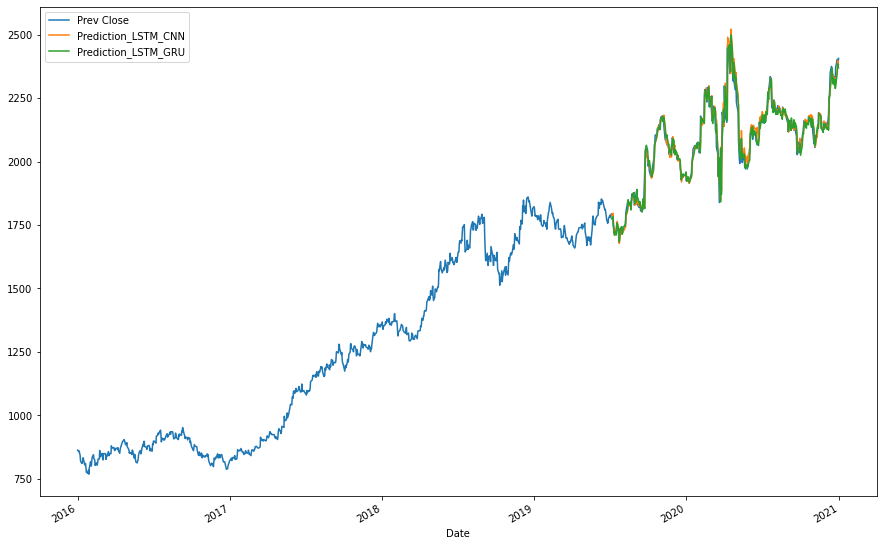

In [312]:
df[['Prev Close' ,'Prediction_LSTM_CNN','Prediction_LSTM_GRU']].plot(figsize=(15,10));

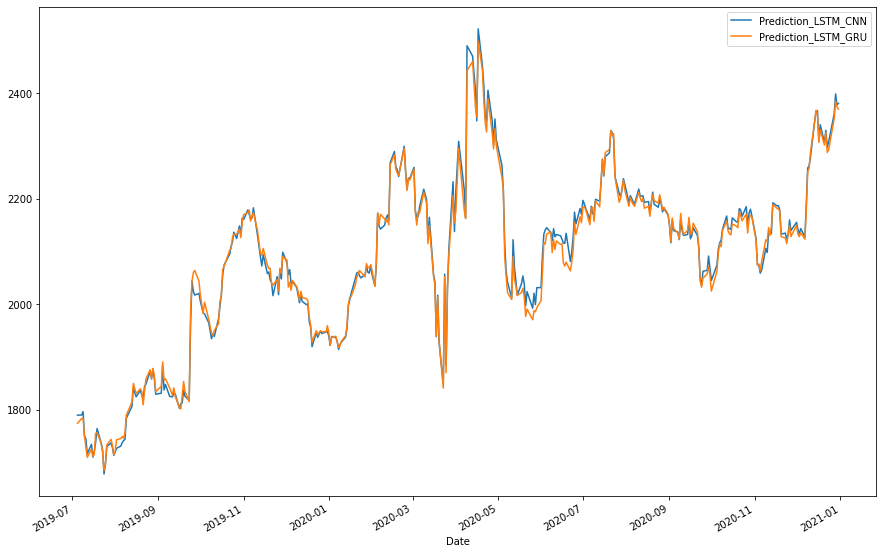

In [313]:
df[['Prediction_LSTM_CNN','Prediction_LSTM_GRU']].plot(figsize=(15,10));

In [314]:
pred_lstm_cnn=df['Prediction_LSTM_CNN']
pred_lstm_cnn.dropna(inplace=True)

In [315]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_lstm_cnn))
print(rmse)

41.883316810987175


In [316]:
error=mean_absolute_error(test['Prev Close'],pred_lstm_cnn)
print(error)

27.59050475033828


In [317]:
r2_score(test['Prev Close'],pred_lstm_cnn)

0.9326688512625824

In [318]:
pred_lstm_gru=df['Prediction_LSTM_GRU']
pred_lstm_gru.dropna(inplace=True)

In [319]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_lstm_cnn))
print(rmse)

41.883316810987175


In [320]:
error=mean_absolute_error(test['Prev Close'],pred_lstm_gru)
print(error)

26.534227722721305


In [321]:
r2_score(test['Prev Close'],pred_lstm_gru)

0.9369135305468966